## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white', color_map = 'RdPu',)

## Read in data

In [4]:
cell = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/scRNA_foetal.h5ad')

# tidy up .var
cell.var=cell.var[['gene_name']]
cell.var.rename(columns={'gene_name':'gene_name_scRNA'},inplace=True)

cell

AnnData object with n_obs × n_vars = 100463 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name_scRNA'
    uns: 'sangerID_colors'
    obsm: 'latent_gene_encoding'

In [5]:
multi = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/QC/multiome_RNA_foetal.h5ad')

# tidy up .var
multi.var=multi.var[['gene_name']]
multi.var.rename(columns={'gene_name':'gene_name_multiome'},inplace=True)

multi

AnnData object with n_obs × n_vars = 211637 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name_multiome'
    uns: 'sangerID_colors'
    obsm: 'latent_gene_encoding'

## Concatenate data

In [6]:
adata = cell.concatenate(multi, join='inner', batch_key=None, index_unique=None)
adata

AnnData object with n_obs × n_vars = 312100 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    obsm: 'latent_gene_encoding'

In [7]:
adata.obs['donor'].value_counts()

Hst41      119101
Hst33       62689
C99         17921
C97         17388
C92         15436
C94         13971
BRC2251      9651
BRC2256      8525
BRC2260      8408
BRC2252      7366
C86          6567
BRC2263      5917
BRC2262      4749
C87          4521
C104         3425
C98          3043
C85          2809
C82           613
Name: donor, dtype: int64

In [8]:
pd.crosstab(adata.obs['facility'],adata.obs['kit_10x'])

kit_10x,3prime-v3,5prime-v2,Multiome-v1
facility,,,
CSCI,44616,0,0
Sanger,0,55847,211637


In [9]:
# save
adata.write('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_raw.h5ad')

... storing 'sangerID' as categorical
... storing 'combinedID' as categorical
... storing 'donor' as categorical
... storing 'region' as categorical
... storing 'region_finest' as categorical
... storing 'age' as categorical
... storing 'gender' as categorical
... storing 'facility' as categorical
... storing 'cell_or_nuclei' as categorical
... storing 'modality' as categorical
... storing 'kit_10x' as categorical
... storing 'scrublet_leiden' as categorical


In [10]:
adata.X.data[:10]

array([ 1.,  1.,  5.,  5.,  8.,  4., 13.,  4.,  3.,  1.], dtype=float32)

## Pre-process

In [11]:
# preserve raw count
adata.layers["counts"] = adata.X.copy()

# filter genes
sc.pp.filter_genes(adata, min_cells=3)

# normalise and log-transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata.shape

filtered out 1734 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:03)


(312100, 34867)

## Set batch_key

In [12]:
# combining Donor, Cell_or_Nuclei, and Kit_10X
adata.obs['batch_key']=adata.obs['donor'].astype('str')+'_'+adata.obs['cell_or_nuclei'].astype('str')+'_'+adata.obs['kit_10x'].astype('str')
adata.obs['batch_key'].value_counts()

Hst41_Nuclei_Multiome-v1    119101
Hst33_Nuclei_Multiome-v1     62689
C99_Cell_5prime-v2           17921
C97_Cell_5prime-v2           17388
C92_Nuclei_Multiome-v1       15436
C94_Cell_5prime-v2           13971
BRC2251_Cell_3prime-v3        9651
BRC2256_Cell_3prime-v3        8525
BRC2260_Cell_3prime-v3        8408
BRC2252_Cell_3prime-v3        7366
C86_Cell_5prime-v2            6567
BRC2263_Cell_3prime-v3        5917
BRC2262_Cell_3prime-v3        4749
C87_Nuclei_Multiome-v1        4521
C104_Nuclei_Multiome-v1       3425
C98_Nuclei_Multiome-v1        3043
C85_Nuclei_Multiome-v1        2809
C82_Nuclei_Multiome-v1         613
Name: batch_key, dtype: int64

## hvg identification

extracting highly variable genes
... storing 'batch_key' as categorical
    finished (0:00:42)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


3317


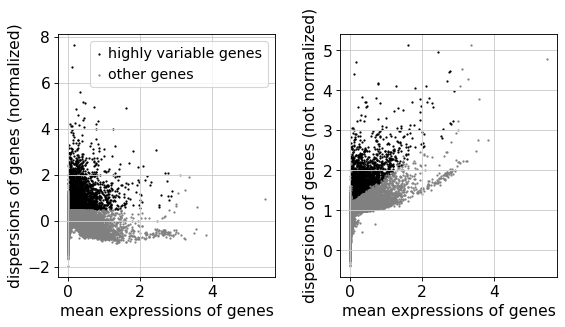

In [13]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key='batch_key')

print(sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata)

In [14]:
# freeze the state in `.raw`
adata.raw = adata

In [15]:
# subset hvgs
adata = adata[:, adata.var.highly_variable]

## Save

In [16]:
adata.write('/nfs/team205/heart/anndata_objects/Foetal/scVI/RNA_foetal_pp.h5ad') # batch_key: Donor, Cell_or_Nuclei, and Kit_10X
adata

View of AnnData object with n_obs × n_vars = 312100 × 3317
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'batch_key'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    obsm: 'latent_gene_encoding'
    layers: 'counts'